# European Centre for Medium Range Weather Forecasts


## Librerías 

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import dask.array as da
from datetime import date, timedelta
import datetime as dt

In [2]:
from dask.distributed import Client
client = Client(n_workers=2)

## Cálculos

In [4]:
files = sorted(glob('2014-*.nc3'))
dss=[nc.Dataset(fns)['t2m'] for fns in files[:90]]
arrays = [da.from_array(dst, chunks=(4,400,500)) for dst in dss]

x=da.concatenate(arrays, axis=0)
x=x.rechunk('auto')
x

dask.array<rechunk-merge, shape=(360, 721, 1440), dtype=int16, chunksize=(64, 721, 1440), chunktype=numpy.MaskedArray>

In [5]:
%%time
varT=x.var(axis=(1,2)).compute()

CPU times: user 10.8 s, sys: 1.26 s, total: 12.1 s
Wall time: 46.5 s


In [7]:
ts=[nc.Dataset(fns)['time'] for fns in files[:90]]
times = [da.from_array(dst, chunks=(1,)) for dst in ts]
times=da.concatenate(times, axis=0)
times=nc.num2date(times,'hours since 1900-01-01 00:00:00.0','gregorian',only_use_cftime_datetimes=False)

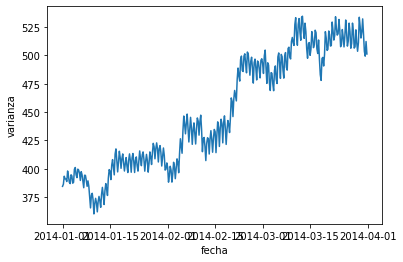

In [8]:
plt.plot(times, varT)
plt.xlabel('fecha')
plt.ylabel('varianza')
plt.show()

In [9]:
prev=(times < dt.datetime(2014,3,1)).data
post=(times >= dt.datetime(2014,3,1)).data

In [10]:
%%time
prevT=x[prev].mean(axis=0).compute()
postT=x[post].mean(axis=0).compute()

CPU times: user 6.85 s, sys: 807 ms, total: 7.66 s
Wall time: 23.8 s


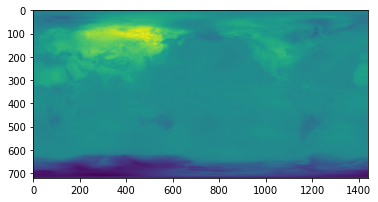

In [11]:
plt.imshow(postT-prevT)

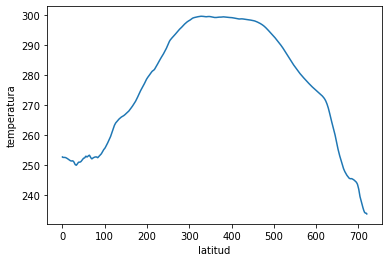

CPU times: user 11.7 s, sys: 1.24 s, total: 12.9 s
Wall time: 47.1 s


In [12]:
%%time
latT=x.mean(axis=(0,2))
lonT=x.mean(axis=(0,1))
da.compute(latT, lonT)

plt.plot(latT)
plt.xlabel('latitud')
plt.ylabel('temperatura')
plt.show()

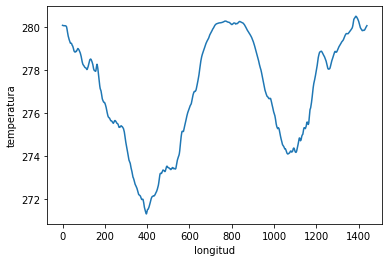

In [13]:
plt.plot(lonT)
plt.xlabel('longitud')
plt.ylabel('temperatura')
plt.show()